NOTEBOOK PARA COMPARATIVAS TTF DE PERIODOS

In [1]:
# -*- coding: utf-8 -*-
import re
from pathlib import Path
from datetime import datetime, timezone, timedelta
import pandas as pd
import dask.dataframe as dd

# === Config ===
PREFIJO_ARCHIVO = "1_filtrado_almacenamiento_posiciones_"  # opcional; pon None para no filtrar por nombre
DATA_DIR = Path(r"c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa")

# Candidatas a columna temporal (ordénalas por preferencia)
TIME_COL_CANDIDATES = ["timestamp", "Timestamp", "time", "Time", "datetime", "DateTime", "fecha", "Fecha"]

print("Ruta elegida:", DATA_DIR)
if not DATA_DIR.exists():
    raise FileNotFoundError(f"No existe la carpeta {DATA_DIR}")

# 1) Localiza archivos parquet (opcionalmente por prefijo)
files = sorted([p for p in DATA_DIR.glob("*.parquet") if (not PREFIJO_ARCHIVO or p.name.startswith(PREFIJO_ARCHIVO))])
if not files:
    raise FileNotFoundError(f"No hay .parquet dentro de {DATA_DIR} (prefijo={PREFIJO_ARCHIVO!r}).")

def detectar_col_tiempo(path: Path) -> str:
    """Intenta detectar el nombre de la columna temporal leyendo solo el esquema."""
    # Leemos solo el meta (Dask elaborará columnas disponibles)
    tmp = dd.read_parquet(str(path), engine="pyarrow")
    cols = list(tmp.columns)
    for c in TIME_COL_CANDIDATES:
        if c in cols:
            return c
    # Si no encontramos, ayudamos con mensaje claro
    raise KeyError(
        f"No se encontró columna temporal en {path.name}. "
        f"Busca alguna de: {TIME_COL_CANDIDATES}. Columnas detectadas: {cols[:50]}"
    )

def rango_temporal_archivo(path: Path, time_col: str):
    """Devuelve (min_ts, max_ts) reales del archivo leyendo solo la columna temporal."""
    ddf = dd.read_parquet(str(path), engine="pyarrow", columns=[time_col])
    # Convertimos a datetime fiable
    ddf = ddf.assign(**{time_col: dd.to_datetime(ddf[time_col], errors="coerce", utc=False)})
    min_ts = ddf[time_col].min().compute()
    max_ts = ddf[time_col].max().compute()
    if pd.isna(min_ts) or pd.isna(max_ts):
        raise ValueError(f"El archivo {path.name} tiene timestamps nulos/no convertibles en la columna {time_col}.")
    return pd.to_datetime(min_ts), pd.to_datetime(max_ts)

# 2) Catalogar por rango temporal REAL (min/max) leyendo la columna timestamp
catalog = []
for f in files:
    try:
        time_col = detectar_col_tiempo(f)
        tmin, tmax = rango_temporal_archivo(f, time_col)
        catalog.append({
            "path": str(f),
            "name": f.name,
            "time_col": time_col,
            "tmin": tmin,
            "tmax": tmax,
            "duracion_dias": (tmax.normalize() - tmin.normalize()).days,
        })
    except Exception as e:
        print(f"[AVISO] Omitiendo {f.name}: {e}")

catalog_df = pd.DataFrame(catalog)
if catalog_df.empty:
    raise RuntimeError("No se pudo catalogar ningún archivo por rango temporal (revisa columnas de tiempo).")

# 3) Selección de Periodo A (más nuevo) y B (más viejo) por tmax descendente
catalog_df = catalog_df.sort_values(["tmax", "tmin"], ascending=[False, False]).reset_index(drop=True)

print("\n=== Catálogo por rango temporal (top) ===")
print(catalog_df.head(10).to_string(index=False))

if len(catalog_df) < 2:
    raise RuntimeError("Necesitas al menos dos datasets para comparar Periodo A y B.")

periodo_A = catalog_df.iloc[0].to_dict()  # más reciente por tmax
periodo_B = catalog_df.iloc[1].to_dict()  # siguiente más reciente

def fmt_ts(ts):
    # imprime con fecha y hora si aporta; si prefieres solo fecha usa .date().isoformat()
    return pd.to_datetime(ts).isoformat()

print("\n=== Selección de Periodos (por tmax) ===")
print(f"Periodo A (más nuevo): {periodo_A['name']}")
print(f"  • Rango real: {fmt_ts(periodo_A['tmin'])} → {fmt_ts(periodo_A['tmax'])}  (~{periodo_A['duracion_dias']} días)")
print(f"Periodo B (más viejo): {periodo_B['name']}")
print(f"  • Rango real: {fmt_ts(periodo_B['tmin'])} → {fmt_ts(periodo_B['tmax'])}  (~{periodo_B['duracion_dias']} días)")

# 4) Cargar DataFrames Dask completos (ya sabemos su columna de tiempo)
df_A = dd.read_parquet(periodo_A["path"], engine="pyarrow")
df_B = dd.read_parquet(periodo_B["path"], engine="pyarrow")

# 5) Metadatos listos para usar
PERIODO_A_INFO = {
    "label": "Periodo A (más nuevo)",
    "path": periodo_A["path"],
    "nombre_archivo": periodo_A["name"],
    "time_col": periodo_A["time_col"],
    "rango_inicio": periodo_A["tmin"],
    "rango_fin": periodo_A["tmax"],
    "df": df_A,
}
PERIODO_B_INFO = {
    "label": "Periodo B (más viejo)",
    "path": periodo_B["path"],
    "nombre_archivo": periodo_B["name"],
    "time_col": periodo_B["time_col"],
    "rango_inicio": periodo_B["tmin"],
    "rango_fin": periodo_B["tmax"],
    "df": df_B,
}

# (Opcional) tamaños rápidos
try:
    nrows_A = df_A.shape[0].compute(); ncols_A = len(df_A.columns)
    nrows_B = df_B.shape[0].compute(); ncols_B = len(df_B.columns)
    print(f"\nForma A: ({nrows_A:,}, {ncols_A}) | {Path(periodo_A['path']).name}")
    print(f"Forma B: ({nrows_B:,}, {ncols_B}) | {Path(periodo_B['path']).name}")
except Exception as e:
    print("(Info) No se pudo computar la forma ahora:", e)


Ruta elegida: c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa

=== Catálogo por rango temporal (top) ===
                                                                                                                                   path                                                              name  time_col                             tmin                             tmax  duracion_dias
 c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa\1_filtrado_almacenamiento_posiciones_7dias_20251007_1118.parquet  1_filtrado_almacenamiento_posiciones_7dias_20251007_1118.parquet timestamp 2025-09-30 00:00:01.631138+00:00        2025-10-06 23:59:57+00:00              6
 c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa\1_filtrado_almacenamiento_posiciones_7dias_20251007_1115.parquet  1_filtrado_almacenamiento_posiciones_7dias_20251007_1115.parquet timestamp 2025-09-24 00:00:00.099751+00:00 2025-09-30 23:59:57.347470+00:00          

In [3]:
cols_info = pd.DataFrame({
    "indice": range(len(df_A.columns)),
    "columna": df_A.columns,
    "tipo_dato": [str(dt) for dt in df_A.dtypes.values]
})

print(cols_info)


    indice           columna            tipo_dato
0        0         device_id               string
1        1     serial_number               string
2        2           dev_eui               string
3        3             model               string
4        4   uplinks_per_day                int64
5        5         timestamp  datetime64[ns, UTC]
6        6       HasLocation                 bool
7        7           IsValid                 bool
8        8     IsLowAccuracy                 bool
9        9     InvalidReason               string
10      10         TimeToFix                int64
11      11               lat              float64
12      12               lon              float64
13      13        ranch_name               string
14      14     customer_name               string
15      15     animal_eartag               string
16      16       animal_name               string
17      17    animal_zone_id               string
18      18        animal_sex               string


In [5]:
# =========================
# 6) Filtrado inicial por ranch_name y model → convertir a pandas.DataFrame
# =========================

# Lista de modelos permitidos
models = ["ixo_track_pro", "cow_pro"]

# Función de filtrado genérica
def filtrar_dataset(df, models):
    return df[
        df["model"].isin(models)
    ]

# Filtrar en Dask
df_A_filtrado = filtrar_dataset(df_A, models)
df_B_filtrado = filtrar_dataset(df_B, models)

# Convertir a pandas.DataFrame
df_A_filtrado_pd = df_A_filtrado.compute()
df_B_filtrado_pd = df_B_filtrado.compute()

# Ver primeras filas y tamaños
print("\n=== Periodo A filtrado (pandas) ===")
print(df_A_filtrado_pd.head())
print("Filas filtradas A:", len(df_A_filtrado_pd))

print("\n=== Periodo B filtrado (pandas) ===")
print(df_B_filtrado_pd.head())
print("Filas filtradas B:", len(df_B_filtrado_pd))



=== Periodo A filtrado (pandas) ===
                                  device_id  ...      dev_eui_norm
index                                        ...                  
0      75b6799a-71ea-4fac-9ef1-a542eb987f92  ...  8c1f64465000091a
1      6b9fd71a-6c18-4f7b-9fc6-53baa98a5f7a  ...  8c1f6446500011c2
2      4ea90db5-38e2-4964-b5ac-cd6ab0074559  ...  8c1f644650000ef8
3      ba48d65d-4108-438d-8393-b0d4b61e8638  ...  8c1f644650000def
4      a126e797-75d7-44b2-a196-97e99e6c7787  ...  8c1f644650000d80

[5 rows x 24 columns]
Filas filtradas A: 827445

=== Periodo B filtrado (pandas) ===
                                  device_id  ...      dev_eui_norm
index                                        ...                  
0      8fcf409e-e2d4-47bb-9df4-db15c9d48cf9  ...  8c1f6446500015ea
1      aa779e5d-5747-4e9a-aec7-4b180cf43c91  ...  8c1f6446500007bf
2      8f652358-6d71-4771-ac9b-b294214aa4f1  ...  8c1f644650000ebd
3      414ac8be-5fd3-497a-80e1-b28b14e11c98  ...  8c1f6446500010d5
4     

In [8]:
# =========================
# Promedio TTF por dispositivo: Periodo A vs Periodo B (ya filtrados)
# =========================
import os
from pathlib import Path
import numpy as np
import pandas as pd

rango_A = f"{PERIODO_A_INFO['rango_inicio'].date()} → {PERIODO_A_INFO['rango_fin'].date()}"
rango_B = f"{PERIODO_B_INFO['rango_inicio'].date()} → {PERIODO_B_INFO['rango_fin'].date()}"

def resumen_por_dispositivo(df: pd.DataFrame,
                            ttf_col: str = "TimeToFix",
                            device_col: str = "device_id",
                            serial_col: str = "serial_number",
                            extras: list[str] = None) -> pd.DataFrame:
    """
    Devuelve DataFrame con promedio TimeToFix por dispositivo.
    Columnas:
      - device_id, serial_number
      - ttf_mean, n_msgs
      - extras opcionales (ej. ranch_name, model)
    """
    if extras is None:
        extras = []

    df = df.copy()
    df[ttf_col] = pd.to_numeric(df[ttf_col], errors="coerce")

    g = df.groupby([device_col, serial_col])
    agg = {
        ttf_col: "mean"
    }
    out = g.agg(agg).rename(columns={ttf_col: "ttf_mean"}).reset_index()

    out["n_msgs"] = g[ttf_col].count().values

    # Añadir extras: tomamos el primer valor por grupo
    for c in extras:
        if c in df.columns:
            out[c] = g[c].first().values

    return out

# --- Ejecutar resúmenes
extras = ["ranch_name", "model"]  # opcional
res_A = resumen_por_dispositivo(df_A_filtrado_pd, extras=extras)
res_B = resumen_por_dispositivo(df_B_filtrado_pd, extras=extras)

# Renombrar columnas con contexto
res_A = res_A.rename(columns={
    "ttf_mean": "Periodo A (promedio TTF)",
    "n_msgs":   f"n_msgs_A ({rango_A})"
})
res_B = res_B.rename(columns={
    "ttf_mean": "Periodo B (promedio TTF)",
    "n_msgs":   f"n_msgs_B ({rango_B})"
})

# Merge A vs B
resultado = pd.merge(
    res_B, res_A,
    on=["device_id", "serial_number"],
    how="outer"
)

# Calcular diferencias
resultado["Diferencia (B - A)"] = (
    resultado["Periodo B (promedio TTF)"] - resultado["Periodo A (promedio TTF)"]
)
resultado["% diferencia vs A"] = np.where(
    (resultado["Periodo A (promedio TTF)"].notna()) & (resultado["Periodo A (promedio TTF)"] != 0),
    100.0 * resultado["Diferencia (B - A)"] / resultado["Periodo A (promedio TTF)"],
    np.nan
)

# Orden columnas
cols_order = [
    "device_id","serial_number","model","ranch_name",
    "Periodo B (promedio TTF)", f"n_msgs_B ({rango_B})",
    "Periodo A (promedio TTF)", f"n_msgs_A ({rango_A})",
    "Diferencia (B - A)","% diferencia vs A"
]
resultado = resultado[[c for c in cols_order if c in resultado.columns]].sort_values("Diferencia (B - A)", ascending=False)

# Mostrar
print("\n=== Comparativa por dispositivo (head) ===")
print(resultado.head(20).to_string(index=False))

# Exportar a Escritorio
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
Path(desktop).mkdir(parents=True, exist_ok=True)

fname = f"comparativa_ttf_dispositivo_{PERIODO_B_INFO['rango_inicio'].date()}_vs_{PERIODO_A_INFO['rango_inicio'].date()}.csv"
out_path = os.path.join(desktop, fname.replace(":", "-"))
resultado.to_csv(out_path, index=False)

print(f"\n✅ Exportado CSV a: {out_path}")



=== Comparativa por dispositivo (head) ===
                           device_id serial_number  Periodo B (promedio TTF)  n_msgs_B (2025-09-24 → 2025-09-30)  Periodo A (promedio TTF)  n_msgs_A (2025-09-30 → 2025-10-06)  Diferencia (B - A)  % diferencia vs A
65f7f3a4-f894-4652-8d0e-444f052fb62a      70017491                 60.000000                                 5.0                 12.527363                               402.0           47.472637         378.951549
492153fb-5690-40de-bd3b-64612d72ada6      70017486                 60.000000                                 5.0                 14.747841                               579.0           45.252159         306.839208
141bbe77-2e0f-47a5-a60e-3559737c5bd3      70017494                 60.000000                                 7.0                 14.826693                               502.0           45.173307         304.675534
3670d117-a86e-4b7e-87dd-2b469a3b77c3      70017493                 60.000000                        

In [9]:
# --- Guardar resultados en CSV en el Escritorio ---
import os

usuario = os.getlogin()
desktop = os.path.join("C:\\Users", usuario, "Desktop")
out_path = os.path.join(desktop, "resultado_ganaderia.csv")

resultado.to_csv(out_path, index=False, encoding="utf-8-sig")  # utf-8-sig para acentos en Excel
print(f"\n✅ CSV exportado en: {out_path}")



✅ CSV exportado en: C:\Users\usuario\Desktop\resultado_ganaderia.csv


✅ Exportado: C:\Users\usuario\Desktop\ttf_media_diaria_global.csv


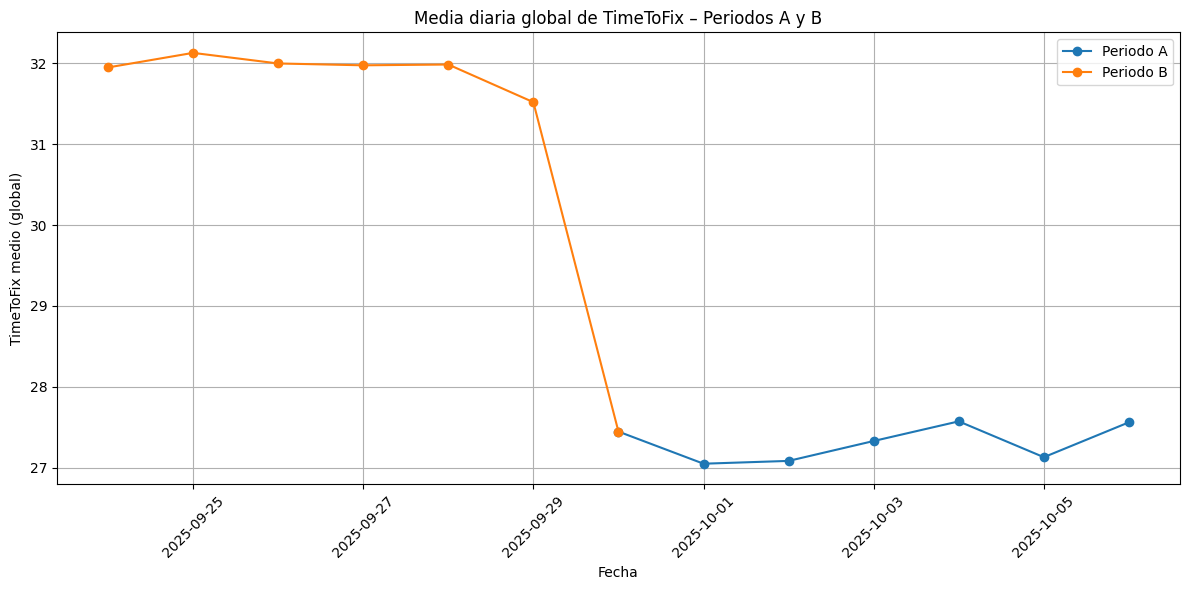

In [10]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# --- Asegurar tipos correctos ---
for df in (df_A_filtrado_pd, df_B_filtrado_pd):
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    df["TimeToFix"] = pd.to_numeric(df["TimeToFix"], errors="coerce")
    # Día en UTC (cambia a Europe/Madrid si quieres local)
    df["fecha"] = df["timestamp"].dt.tz_convert("UTC").dt.date

# === Promedio diario GLOBAL (todos los mensajes de todos los dispositivos) ===
df_a_daily = (
    df_A_filtrado_pd.groupby("fecha")["TimeToFix"]
      .mean()
      .reset_index()
      .sort_values("fecha")
)
df_a_daily["periodo"] = "A"

df_b_daily = (
    df_B_filtrado_pd.groupby("fecha")["TimeToFix"]
      .mean()
      .reset_index()
      .sort_values("fecha")
)
df_b_daily["periodo"] = "B"

# Concatenar resultados
df_total = pd.concat([df_a_daily, df_b_daily], ignore_index=True)

# === Exportar a CSV ===
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
Path(desktop).mkdir(parents=True, exist_ok=True)
csv_path = os.path.join(desktop, "ttf_media_diaria_global.csv")
df_total.to_csv(csv_path, index=False)
print(f"✅ Exportado: {csv_path}")

# === Gráfico ===
plt.figure(figsize=(12, 6))
for periodo, df_sub in df_total.groupby("periodo"):
    plt.plot(df_sub["fecha"], df_sub["TimeToFix"], marker="o", label=f"Periodo {periodo}")

plt.title("Media diaria global de TimeToFix – Periodos A y B")
plt.xlabel("Fecha")
plt.ylabel("TimeToFix medio (global)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
